In [4]:
%matplotlib inline

import numpy as np
from tqdm import tqdm

In [5]:
class Venus:
    
    def __init__(
        self,
        inj_limits=[175, 185],
        mid_limits=[145, 155],
        ext_limits=[135, 145],
        beam_range=[50, 100],
        jitter=0
    ):
        """The limits on the magnetic solenoids currents and the beam range (ouput).
        A random jitter can be added also (fraction of 1.)."""
        self.inj_limits = inj_limits
        self.mid_limits = mid_limits
        self.ext_limits = ext_limits
        self.beam_range = beam_range
        self.currents = np.zeros(3)
        self.jitter = jitter
        self.rng = np.random.default_rng(42)

    def set_mag_currents(self, inj, mid, ext):
        """Set the magnetic currents on the coils."""
        for v, lim in zip([inj, mid, ext], [self.inj_limits, self.mid_limits, self.ext_limits]):
            if v < lim[0] or v > lim[1]:
                raise ValueError("Setting outside limits")
        self.currents = np.array([inj, mid, ext])

    def _rescale_inputs(self, inputs):
        """input to himmelblau4 must be in [-6, 6]."""
        return (
            (c - l[0]) * 12.0 / (l[1] - l[0]) - 6.0
            for c, l in zip(inputs, [self.inj_limits, self.mid_limits, self.ext_limits])
        )
    
    def get_noise_level(self):
        # return std of the noise
        noise = self.jitter*(self.beam_range[1] - self.beam_range[0])
        return noise
    
    def get_bounds(self, i):
        if i == 0:
            return self.inj_limits
        elif i==1:
            return self.mid_limits
        elif i==2:
            return self.ext_limits
    
    def _rescale_output(self, output):
        """himmelblau4 returns values betwen 0 and 4899 for w, x, y, z in [-6, 6]."""
        return (
            (1. - (output / 4899) + self.rng.normal(0.0, self.jitter)) *
            (self.beam_range[1] - self.beam_range[0]) + self.beam_range[0]
        )

    def get_beam_current(self):
        """Read the current value of the beam current"""
        return self._rescale_output(self._himmelblau4(*self._rescale_inputs(self.currents)))

    @staticmethod
    def _himmelblau4(w, x, y):
        """A funky 4 dimensional parameter space with a bunch of local minima."""
        return (
            (w**2 + x + y - 11)**2 +
            (w + x**2 + y - 7)**2 +
            (w + x + y**2 - 5)**2
        )

create a venus object, defaults might be refined by values from Damon. For simpler algorithm the jitter can be set to 0 initially but it should work with a value larger than that in the end.

In [6]:
venus = Venus(jitter=0.0)

set the currents and read the beam value

In [7]:
venus.set_mag_currents(185, 155, 145)
bc = venus.get_beam_current()
print(bc)

50.0


if currents are outside the range a `ValueError` is raised and can be captured.

In [8]:
venus.set_mag_currents(50, 200, 200)

ValueError: Setting outside limits

In [9]:
venus._himmelblau4(6, 6, 6)

4899

# Bayesian Optimization

In [10]:
import numpy as np
import matplotlib.pyplot as plt

from bayes_opt import BayesianOptimization, UtilityFunction
import warnings
warnings.filterwarnings("ignore")

# Define the black box function to optimize.
def black_box_function(A, B, C):
    # C: SVC hyper parameter to optimize for.
    venus.set_mag_currents(A, B, C)
    v = venus.get_beam_current()
    return v

# Set range of C to optimize for.
# bayes_opt requires this to be a dictionary.
pbounds = {"A": [175, 185], "B": [145, 155], "C": [135, 145]}
# Create a BayesianOptimization optimizer,
# and optimize the given black_box_function.
optimizer = BayesianOptimization(f = black_box_function,
                                 pbounds = pbounds, verbose = 2,
                                 random_state = 38)
optimizer.maximize(init_points = 5, n_iter = 40, kappa=2.3, alpha=0.05)
print("Best result: {}; f(x) = {}.".format(optimizer.max["params"], optimizer.max["target"]))

|   iter    |  target   |     A     |     B     |     C     |
-------------------------------------------------------------
|  1        |  90.43    |  178.8    |  153.6    |  144.4    |
|  2        |  99.94    |  182.0    |  151.3    |  141.1    |
|  3        |  98.53    |  177.0    |  148.9    |  137.6    |
|  4        |  96.73    |  175.7    |  147.8    |  139.4    |
|  5        |  97.96    |  179.8    |  153.7    |  140.3    |
|  6        |  98.83    |  180.9    |  151.0    |  139.4    |
|  7        |  94.9     |  184.5    |  152.5    |  139.6    |
|  8        |  99.36    |  181.5    |  149.4    |  141.3    |
|  9        |  96.66    |  183.7    |  149.6    |  143.2    |
|  10       |  97.42    |  180.3    |  147.8    |  138.7    |
|  11       |  98.62    |  177.9    |  151.9    |  137.1    |
|  12       |  88.21    |  175.6    |  150.5    |  135.0    |
|  13       |  98.26    |  178.3    |  150.5    |  139.3    |
|  14       |  97.41    |  180.0    |  153.4    |  137.2    |
|  15   

In [11]:
import random
# try a certain times and see how many converges
def trial(N, n_iter = 15, init_points = 5, kappa = 3, verbose = 0, rand_adder = 0):
    # higher kappa prefers exploration
    # initial points are randomly chosen within bounds
    # rand_adder is to make sure we probe some different randstates in each trial
    # rand_adder = random.randint(1,1000)
    results = []
    coords = []
    pbounds = {"A": (175, 185), "B": (145, 155), "C": (135, 145)}
    noise = max(venus.get_noise_level(), 1e-5)

    for i in tqdm(range(N)):
        # Create a BayesianOptimization optimizer,
        # and optimize the given black_box_function.
        optimizer = BayesianOptimization(f = black_box_function,
                                         pbounds = pbounds, verbose = 0)
                                         # random_state = i+rand_adder)
        optimizer.maximize(init_points = init_points, n_iter = n_iter, kappa=kappa, alpha=0.05) # 
        if verbose>1:
            print("Best result: {}; f(x) = {}.".format(optimizer.max["params"], optimizer.max["target"]))
        results.append(optimizer.max["target"])
        coords.append(optimizer.max["params"])
        del optimizer
    
    plt.title("n_iter = {}, init_points = {}, kappa = {}".format(n_iter, init_points, kappa))
    plt.hist(results)
    plt.show()
    
    plt.scatter([coords[i]['A'] for i in range(len(coords))], [coords[i]['B'] for i in range(len(coords))]) #, [coords[i]['C'] for i in range(len(coords))]
    plt.xlim(pbounds['A'][0], pbounds['A'][1])
    plt.ylim(pbounds['B'][0], pbounds['B'][1])
    # ax.set_zlim3d(pbounds['C'][0], pbounds['C'][1])
    
    plt.scatter([182.5], [151.7], s=180, marker="*") # , [140.0]
    plt.show()
    if verbose > 0:
        print(list(reversed(sorted(results))))    

## Simple Trial

100%|█████████████████████████████████████████████| 1/1 [00:03<00:00,  3.36s/it]

Best result: {'A': 182.64679810774365, 'B': 151.90007771565553, 'C': 139.4584760992156}; f(x) = 99.98149078332482.


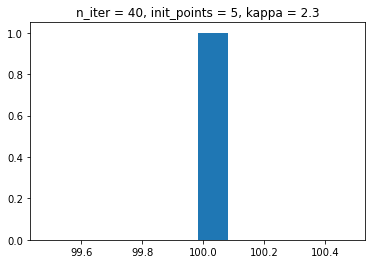

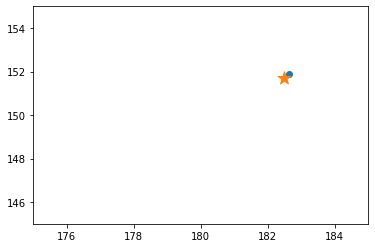

[99.98149078332482]


In [12]:
trial(1, n_iter = 40, init_points = 5, kappa = 2.3, verbose = 2)

## Making sure our method is better than random

100%|███████████████████████████████████████████| 50/50 [01:22<00:00,  1.65s/it]


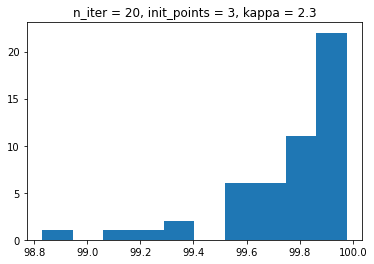

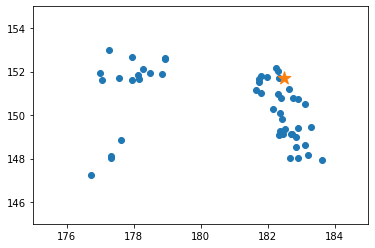

[99.97635378335946, 99.97554495140244, 99.95615802074354, 99.95544432437907, 99.95349975200655, 99.94366705899681, 99.94103496101101, 99.93814360875218, 99.93513703507335, 99.93381364411309, 99.92588453430756, 99.92570900763951, 99.92435067650598, 99.91871994904685, 99.91244306399855, 99.90311137256498, 99.90059348978635, 99.88443460083485, 99.87501127669466, 99.87380818490081, 99.86929892195559, 99.8624176292855, 99.8414130080547, 99.83005560094311, 99.8194209568534, 99.81904217701694, 99.81662626330612, 99.80882236553381, 99.78868396381968, 99.78180946008251, 99.77178938692677, 99.77029197672144, 99.7490401628142, 99.74186686276047, 99.69713433712573, 99.6881729205729, 99.67637086565169, 99.6667548466919, 99.66401827210098, 99.58320083609534, 99.54810589206647, 99.53520712335185, 99.53188221717176, 99.52089461045014, 99.52081145003005, 99.32954786440152, 99.30089523498756, 99.28294072592233, 99.120958552096, 98.83013261562101]


In [13]:
trial(50, n_iter = 20, init_points = 3, kappa = 2.3, verbose = 1)

100%|███████████████████████████████████████████| 50/50 [00:12<00:00,  4.06it/s]


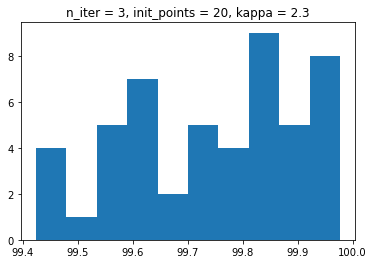

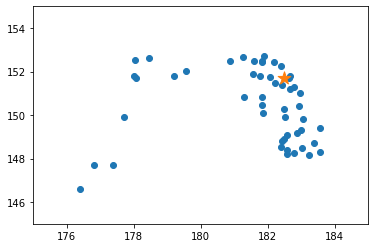

[99.97746692929877, 99.96303517765057, 99.95533823177844, 99.95403062428784, 99.94384572711131, 99.93648249218688, 99.93133602478443, 99.92975989916104, 99.91491662462984, 99.9144977181428, 99.90973488854208, 99.90127165140329, 99.87476413355411, 99.86209936420155, 99.8618772534235, 99.85070866660277, 99.84746464683704, 99.84620768009292, 99.82729765248286, 99.82002090646563, 99.81977510482544, 99.81731807923813, 99.80817167905867, 99.80526687664069, 99.76844006076519, 99.75928328149377, 99.74263398290432, 99.73100770650237, 99.72766676645446, 99.72293805002121, 99.70062134469576, 99.67855798972477, 99.65114933563626, 99.63186343041048, 99.62776474280108, 99.6179164631063, 99.60548046269136, 99.59912492218042, 99.59707548926517, 99.59696049385018, 99.5768243004697, 99.57639920254474, 99.57582154650538, 99.55314669469485, 99.55207933821555, 99.4996753993938, 99.45224399057118, 99.4521401932331, 99.4359471416639, 99.42367682342886]


In [14]:
# we see that more iteration is better than more initial points, meaning our sampling is more efficient than random sample
trial(50, n_iter = 3, init_points = 20, kappa = 2.3, verbose = 1)

## Trying out kappa

100%|███████████████████████████████████████████| 30/30 [01:08<00:00,  2.29s/it]


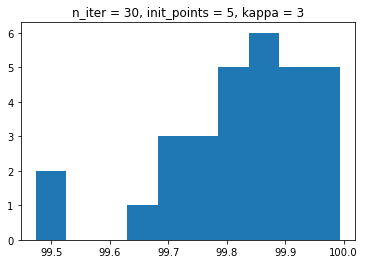

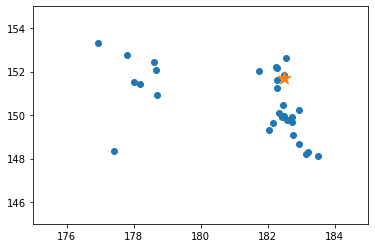

[99.99418786575826, 99.99371354072389, 99.9643646872874, 99.9531877664441, 99.95134179430619, 99.9365611032526, 99.93052944484651, 99.92379840464054, 99.92048472534054, 99.91018681199814, 99.86166566413843, 99.86066922768808, 99.85499894930174, 99.85020515922076, 99.84864364051451, 99.83795970944709, 99.81993078831572, 99.81402432627834, 99.80963450641306, 99.80492878155188, 99.80289372121345, 99.76688557959471, 99.75265737189508, 99.74709743606407, 99.72767322974644, 99.72238977660567, 99.7208885663738, 99.66956677641184, 99.47862570214697, 99.47331812698448]


In [15]:
trial(30, n_iter = 30, init_points = 5, kappa = 3, verbose = 1)

100%|███████████████████████████████████████████| 30/30 [01:10<00:00,  2.34s/it]


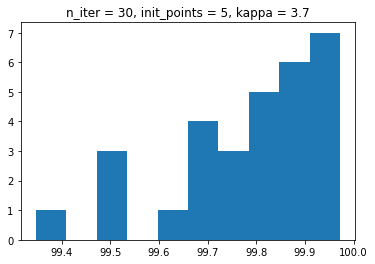

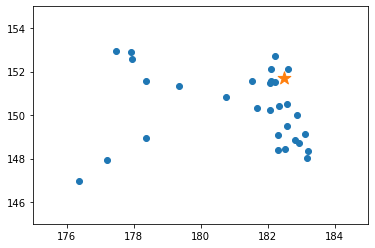

[99.97235060417634, 99.96307748310699, 99.94448475383258, 99.93024356973098, 99.92533639007277, 99.92005447502467, 99.91208899354515, 99.9071294166826, 99.89540401468915, 99.89048218738388, 99.88372603923841, 99.85924104886428, 99.84730507567478, 99.84017338892124, 99.83895857019009, 99.82756414871102, 99.81404170860867, 99.80068849066821, 99.77721641908622, 99.74145824200713, 99.72508198102895, 99.71389373211713, 99.71301709426582, 99.6894460309896, 99.68156087744623, 99.65915584365305, 99.48423842869312, 99.48114403867962, 99.47269369031936, 99.34670831933428]


In [16]:
trial(30, n_iter = 30, init_points = 5, kappa = 3.7, verbose = 1)

100%|███████████████████████████████████████████| 30/30 [01:11<00:00,  2.39s/it]


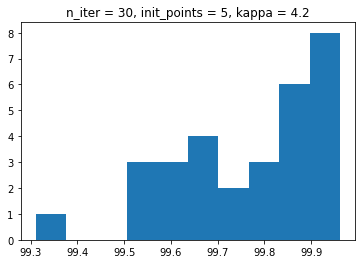

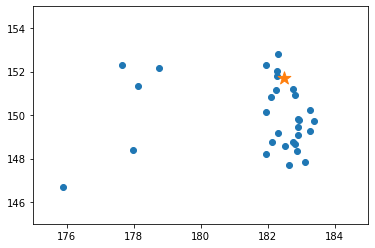

[99.96192940174276, 99.95437378497533, 99.93892163889679, 99.9362560415162, 99.93523496834104, 99.9295344459527, 99.92737174109621, 99.90238593492684, 99.89400312928936, 99.88617396208795, 99.88527865794774, 99.87880795278252, 99.86405566765035, 99.83872729334607, 99.81498277927034, 99.79480958346826, 99.78854489462044, 99.76642317908627, 99.71622263895418, 99.69984172874454, 99.67136192117393, 99.66320335310735, 99.64068773141159, 99.63369560533391, 99.5998024412932, 99.58200527893129, 99.56821604082981, 99.53308800935771, 99.51066458525898, 99.31086937669855]


In [17]:
trial(30, n_iter = 30, init_points = 5, kappa = 4.2, verbose = 1)

100%|███████████████████████████████████████████| 30/30 [01:14<00:00,  2.49s/it]


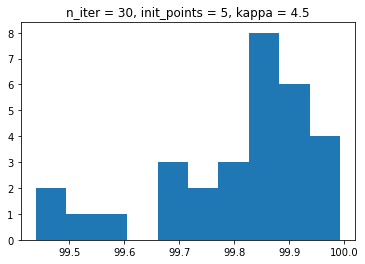

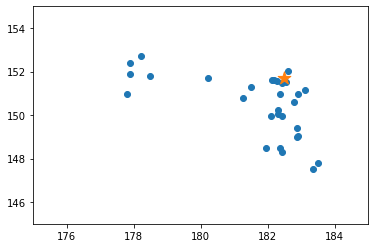

[99.99274219817902, 99.96352167887102, 99.95887732516566, 99.95220970428086, 99.91432353391667, 99.9092658422997, 99.9079825901371, 99.90020627743229, 99.88478857144409, 99.8846996183658, 99.88117923085466, 99.86940978039357, 99.865266741776, 99.86211705352594, 99.86020555016492, 99.84829705992428, 99.83339758601365, 99.8309851462947, 99.79766482335961, 99.79750924913503, 99.79473185728165, 99.76491074599642, 99.76344724608389, 99.70799196149028, 99.67321009679759, 99.6693304167013, 99.56280067829128, 99.54863078988876, 99.49434656531278, 99.43944556626613]


In [18]:
trial(30, n_iter = 30, init_points = 5, kappa = 4.5, verbose = 1)

## Increase n_iter

100%|███████████████████████████████████████████| 30/30 [03:06<00:00,  6.21s/it]


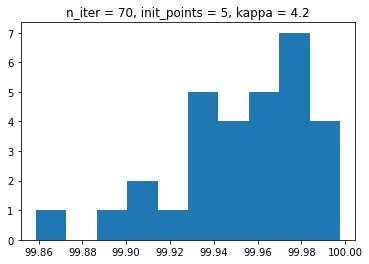

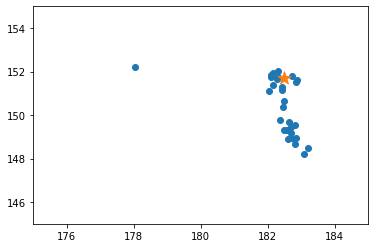

[99.99768542590486, 99.99730472868154, 99.98698432289797, 99.9850982311227, 99.98357210808965, 99.97810294600504, 99.97555481633265, 99.97408360106337, 99.97354595651488, 99.97198026772571, 99.9709874861559, 99.96883629427344, 99.9619328672236, 99.96070600324076, 99.95867595187057, 99.95682876119696, 99.95271339204471, 99.95129985425976, 99.94584612723611, 99.94484620902494, 99.9420564695278, 99.9407512461778, 99.93895841038719, 99.93459161295783, 99.93023717439328, 99.91753715256266, 99.91402782119803, 99.90069144243287, 99.89573570526125, 99.85871477082028]


In [19]:
trial(30, n_iter = 70, init_points = 5, kappa = 4.2, verbose = 1)

100%|███████████████████████████████████████████| 30/30 [03:08<00:00,  6.29s/it]


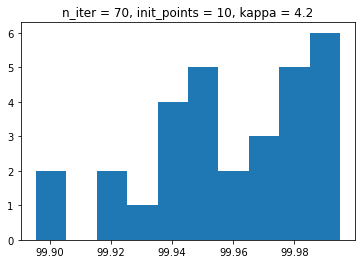

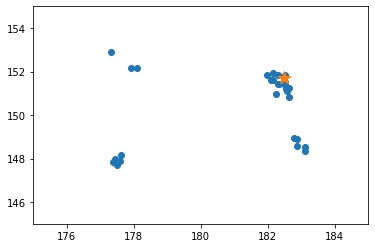

[99.99500874770965, 99.99452089669938, 99.99449693063305, 99.99394951572623, 99.99194426269429, 99.98932133098637, 99.98467381436242, 99.98432914897509, 99.98178178383637, 99.98088788349378, 99.97532438326385, 99.97290610292782, 99.97219832206815, 99.96578923350602, 99.96503409772936, 99.9637018472553, 99.95389818260803, 99.95328182081397, 99.94802630739756, 99.94799154414136, 99.94670390130057, 99.94250882284271, 99.94143765783781, 99.93982703800569, 99.93625663601964, 99.9319306857508, 99.92381315887312, 99.92154251391358, 99.90486538785234, 99.89532259256603]


In [20]:
trial(30, n_iter = 70, init_points = 10, kappa = 4.2, verbose = 1)

100%|███████████████████████████████████████████| 30/30 [03:11<00:00,  6.38s/it]


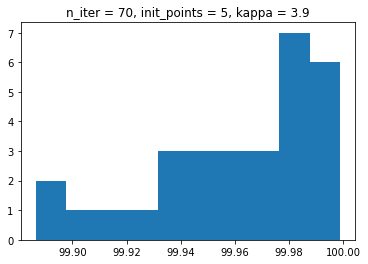

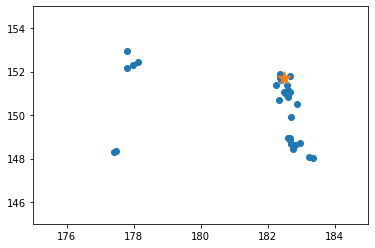

[99.99877403474457, 99.9978655347291, 99.99743637805923, 99.99256722447186, 99.99002250656287, 99.98878461953434, 99.98720145898392, 99.98625992982686, 99.98608115929792, 99.98472630262408, 99.98366026232341, 99.98274741344419, 99.97650606947394, 99.9756640828914, 99.97217268597663, 99.97200270754172, 99.96354366185655, 99.96122139406185, 99.95891199255848, 99.94967482817495, 99.94747157068298, 99.94487892035582, 99.94220462039394, 99.93639320896784, 99.93223320843614, 99.93035993917599, 99.91157725806161, 99.90339158238108, 99.8878121676083, 99.88653819993567]


In [21]:
trial(30, n_iter = 70, init_points = 5, kappa = 3.9, verbose = 1)

# Try to decrease n_iter but do more trials. Fix kappa at 4.2

100%|█████████████████████████████████████████| 100/100 [01:31<00:00,  1.09it/s]


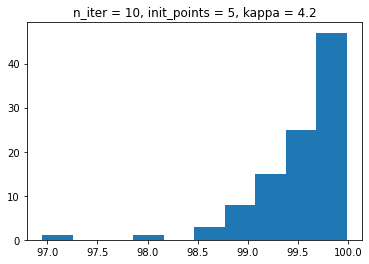

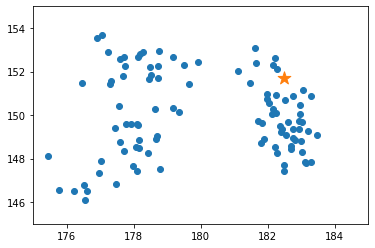

In [22]:
trial(100, n_iter = 10, init_points = 5, kappa = 4.2, verbose = 0)

100%|█████████████████████████████████████████| 100/100 [03:04<00:00,  1.85s/it]


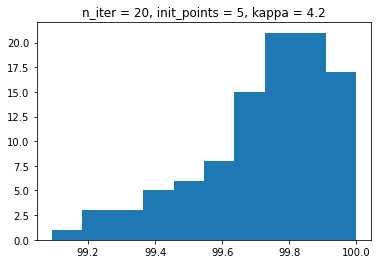

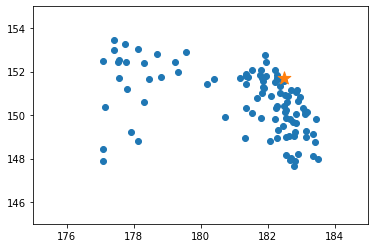

In [23]:
trial(100, n_iter = 20, init_points = 5, kappa = 4.2, verbose = 0)

100%|█████████████████████████████████████████| 100/100 [04:22<00:00,  2.63s/it]


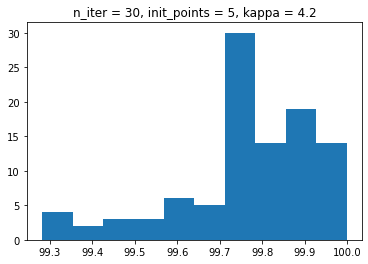

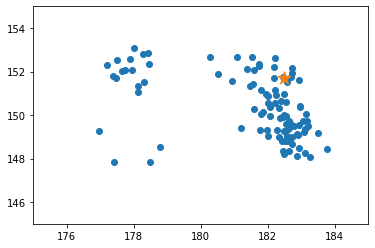

In [24]:
trial(100, n_iter = 30, init_points = 5, kappa = 4.2, verbose = 0)

100%|█████████████████████████████████████████| 100/100 [05:52<00:00,  3.53s/it]


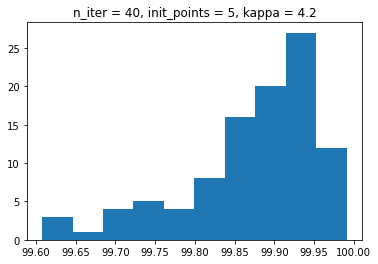

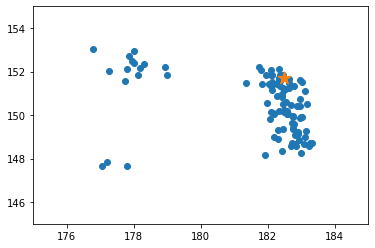

In [25]:
trial(100, n_iter = 40, init_points = 5, kappa = 4.2, verbose = 0)

In [26]:
# TODO: guide optimization to known good points
# TODO: modify the loss function to have larger differences between global min and local min
# TODO: find a way to set halting condition or use a different library

In [27]:
# unused. Potentially for future tests
# from deap import benchmarks

# def ackley_arg0(sol):
#     return benchmarks.ackley(sol)[0]

In [28]:
# ackley_arg0((0,0,0))

In [29]:
# Global min: (182.5, 151.7, 140.0) value
# TODO: use get current function
# scikit optimization
# skopt2